## HW5 Bayesian Regression Analysis

### Author: Seo Won Yi (yiseo)
### Collaborator: Serena Ban

#### Part 1: Bayesian Linear Regression analysis

Using the data from kaggle, we will perform a Bayesian Linear Regression analysis.

In [1]:
# import every necessary modules

import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import pandas as pd

# URL for the dataset obtained from https://www.kaggle.com/datasets/amulyas/penguin-size-dataset/data

data_url = "https://raw.githubusercontent.com/woom221/STA365-UofT/main/HW5/data/penguins_size.csv"

# read the dataset

df = pd.read_csv(data_url)

print(len(df.index))

df.head()

344


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [2]:
# detect how many rows contain missing data for each column

df.shape[0] - df.dropna().shape[0]

10

In [3]:
# we can see that the portion of missing data is around 3%
# for this analysis, we will remove them and conduct Complete Case Analysis

df.dropna(axis=0, inplace=True)

print(len(df.index))

df.head(5)

334


,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [4]:
# first let's observe the data set

# Observe the column variables

print(list(df))

['species', 'island', 'culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [5]:
# observe the unique values in each column

for column in list(df):
  print(df[column].unique())
  print("\n")

['Adelie' 'Chinstrap' 'Gentoo']


['Torgersen' 'Biscoe' 'Dream']


[39.1 39.5 40.3 36.7 39.3 38.9 39.2 41.1 38.6 34.6 36.6 38.7 42.5 34.4
 46.  37.8 37.7 35.9 38.2 38.8 35.3 40.6 40.5 37.9 37.2 40.9 36.4 42.2
 37.6 39.8 36.5 40.8 36.  44.1 37.  39.6 42.3 40.1 35.  42.  34.5 41.4
 39.  35.7 41.3 41.6 35.5 41.8 33.5 39.7 45.8 42.8 36.2 42.1 42.9 35.1
 37.3 36.3 36.9 38.3 34.  38.1 33.1 43.2 41.  45.6 42.7 40.2 35.2 41.5
 38.5 43.1 36.8 37.5 35.6 32.1 40.7 46.5 50.  51.3 45.4 52.7 45.2 46.1
 46.6 51.7 47.  52.  45.9 50.5 50.3 58.  46.4 49.2 42.4 48.5 50.6 46.7
 49.5 52.8 54.2 51.  49.7 47.5 47.6 46.9 53.5 49.  46.2 50.9 45.5 50.8
 50.1 51.5 49.8 48.1 51.4 45.7 50.7 52.2 49.3 50.2 51.9 46.8 55.8 43.5
 49.6 48.7 43.3 48.4 45.1 46.3 47.8 48.2 47.3 59.6 49.1 42.6 44.4 44.
 45.3 43.6 44.9 45.  43.8 50.4 54.3 47.7 48.6 51.1 52.5 47.4 43.4 52.1
 44.5 49.4 55.9 47.2 41.7 53.4 55.1 48.8 49.9]


[18.7 17.4 18.  19.3 20.6 17.8 19.6 17.6 21.2 21.1 19.  20.7 18.4 21.5
 18.3 19.2 18.1 17.2 18.9 18.6 17

In [6]:
# observe the statistical summary

print(df.describe())

       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        334.000000       334.000000         334.000000   334.000000
mean          43.994311        17.160479         201.014970  4209.056886
std            5.460521         1.967909          14.022175   804.836129
min           32.100000        13.100000         172.000000  2700.000000
25%           39.500000        15.600000         190.000000  3550.000000
50%           44.500000        17.300000         197.000000  4050.000000
75%           48.575000        18.700000         213.000000  4793.750000
max           59.600000        21.500000         231.000000  6300.000000


In [7]:
# for this analysis, we will use culmen_length_mm, culmen_depth_mm,
# flipper_length_mm to predict body_mass_g

# choose the predictors and convert them to numpy matrix (334 x 3)
X = df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm"]].values
# choose the response and convert them to numpy matrix (334 X 1)
y = df["body_mass_g"].values.reshape(X.shape[0], 1)

# using the summary statistics from above, set up reasonable prior distribution
n = X.shape[0]
p = X.shape[1]
beta_mu = np.ones((p, 1))
sigma_sigma = np.std(y)

with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=beta_mu, cov=np.eye(p), shape=(p,1))
    sigma = pm.HalfNormal('sigma', sigma=sigma_sigma) # half normal
    y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, shape=(n, 1), observed=y)

with MLR:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'betas': array([[1.002 , 1.0019, 1.0014],
       [1.0001, 1.0001, 1.0013],
       [1.0014, 1.0002, 1.0003]]), 'sigma': 1.0003}


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


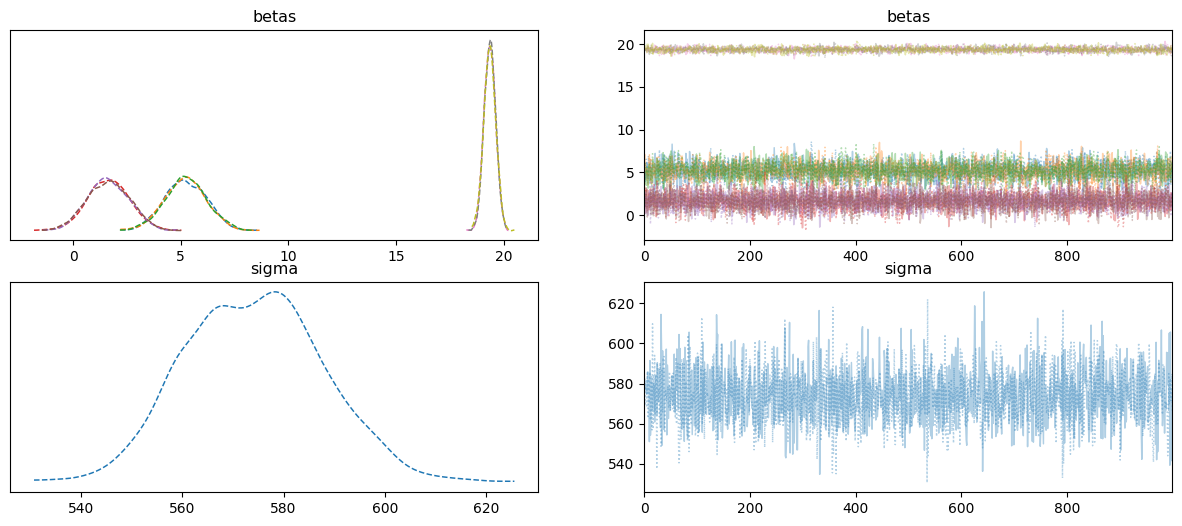

In [8]:
# Check convergence of the chains and check the Rhat value
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()})
f, ax = plt.subplots(2, 2, figsize=(15, 6))
az.plot_trace(idata, combined=True, axes=ax[:2,:2]);

In [9]:
# check effective sample size

az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"betas[0, 0]",5.23,0.97,3.42,6.98,0.02,0.02,1892.38,1431.46,1.0
"betas[0, 1]",5.21,0.96,3.40,6.97,0.02,0.02,1612.74,1163.49,1.0
"betas[0, 2]",5.24,0.97,3.35,7.09,0.02,0.02,1695.29,1508.83,1.0
"betas[1, 0]",1.65,0.98,-0.24,3.43,0.02,0.02,2066.23,1470.36,1.0
"betas[1, 1]",1.64,0.96,-0.15,3.37,0.02,0.01,2443.02,1694.01,1.0
"betas[1, 2]",1.65,0.99,-0.08,3.60,0.02,0.02,2144.79,1485.38,1.0
"betas[2, 0]",19.35,0.27,18.86,19.84,0.01,0.00,1786.75,1707.76,1.0
"betas[2, 1]",19.35,0.26,18.85,19.83,0.01,0.00,1395.05,1381.71,1.0
"betas[2, 2]",19.35,0.28,18.85,19.88,0.01,0.01,1284.96,1431.71,1.0
sigma,574.14,13.65,549.92,599.84,0.25,0.17,3240.35,1451.95,1.0


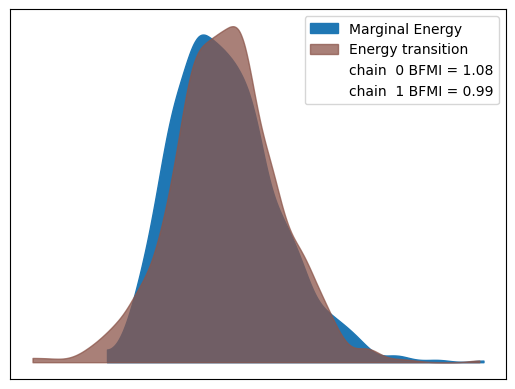

In [10]:
# energy plot

az.plot_energy(idata);

#### Part 2: Multivariate Normal Analysis

1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$ (no longer using $\Sigma$) if $\Sigma=\sigma^2I$

Suppose we are using prior $p(\boldsymbol \beta) = MVN(\boldsymbol \beta_{0}, \boldsymbol\Sigma_{\beta})$

Given $p(\beta| \Sigma, X, y) = \mathcal{MVN}\left(E[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \text{Cov}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}]\bigg( \mathbf{X}^\top \boldsymbol\Sigma^{-1}\mathbf{y} + \boldsymbol \Sigma_\beta^{-1}\boldsymbol\beta_0 \right), \text{Cov}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\left[\mathbf{X}^{\top}\boldsymbol \Sigma^{-1} \mathbf{X} \right] + \boldsymbol \Sigma_\beta)^{-1} \bigg)$

We want to replace $\Sigma$ with $\sigma^{2}I$

We get

$p(\boldsymbol\beta|\boldsymbol\Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y) = MVN(Cov[\boldsymbol\beta | \boldsymbol\Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y](\boldsymbol X^{T}(\sigma^{-2}I)\boldsymbol y + \boldsymbol \Sigma^{-1}_{\beta}\boldsymbol\beta_{0}), Cov[\boldsymbol\beta, \boldsymbol\Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y] = ([\boldsymbol X^{T}(\sigma^{-2}I)\boldsymbol X] + \boldsymbol \Sigma_{\beta}))^{-1}$

which becomes

$p(\boldsymbol \beta|\boldsymbol \Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y) = MVN(Cov[\boldsymbol \beta | \boldsymbol \Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y](\sigma^{-2}\boldsymbol X^{T}\boldsymbol y + \boldsymbol \Sigma^{-1}_{\beta}\boldsymbol \beta_{0}), Cov[\boldsymbol \beta, \boldsymbol \Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y] = ([\sigma^{-2}\boldsymbol X^{T}\boldsymbol X] + \boldsymbol \Sigma_{\beta}))^{-1}$

2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

From above, we know that using prior $p(\boldsymbol \beta) = MVN(\boldsymbol \beta_{0}, \boldsymbol\Sigma_{\beta})$ and $\Sigma=\sigma^2I$, we get

$E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = Cov[\boldsymbol \beta | \boldsymbol \Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y](\sigma^{-2}\boldsymbol X^{T}\boldsymbol y + \boldsymbol \Sigma^{-1}_{\beta}\boldsymbol \beta_{0})$ where $Cov[\boldsymbol \beta, \boldsymbol \Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y] = ([\sigma^{-2}\boldsymbol X^{T}\boldsymbol X] + \boldsymbol \Sigma_{\beta}))^{-1}$

3. What ***hyperparameters*** values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

First, we would need the prior to be $p(\boldsymbol\beta) \propto 1$ to get rid of $\boldsymbol \Sigma_{\beta}^{-1}$ and $\boldsymbol\beta_{0}$.

Then, in order for the $\boldsymbol\Sigma$ to cancel out, we would need $\boldsymbol\Sigma$ to be a digonal matrix with the same elements which would be identical to multiplying a scalar value.

For example, if we have prior $p(\boldsymbol\beta) \propto 1$ and $\boldsymbol\Sigma = \sigma^{2}I$,

$E[\boldsymbol \beta |\boldsymbol\Sigma = \sigma^{2}I, \mathbf{X},\mathbf{y}] = (\boldsymbol X^{T}\boldsymbol(\sigma^{-2}I)\boldsymbol X)^{-1}\boldsymbol X^{T} \boldsymbol(\sigma^{-2}I) \boldsymbol y = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$.

In other words, we would need all the covariance values to be 0 and have a constant variance.

4. What ***hyperparameters*** values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

Since $E[\mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$, if the conditions in question 3 is satisfied, we would have the desired result.

5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

From question 1, we know that using prior $p(\boldsymbol \beta) = MVN(\boldsymbol \beta_{0}, \boldsymbol\Sigma_{\beta})$ and $\Sigma=\sigma^2I$, we get

$Cov[\boldsymbol \beta, \boldsymbol \Sigma = \sigma^{2}I, \boldsymbol X, \boldsymbol y] = ([\sigma^{-2}\boldsymbol X^{T}\boldsymbol X] + \boldsymbol \Sigma_{\beta}))^{-1}$

#### Part 3: Bayesian Multivariate Normal Model using Cholesky factor

We will use the same dataset to perform the Bayesian Multivariate Normal Model analysis

In [11]:
# for this analysis, we will use culmen_length_mm, culmen_depth_mm,
# flipper_length_mm as X and body_mass_g as y

# choose the predictors and convert them to numpy matrix (334 x 3)
X = df[["culmen_length_mm", "culmen_depth_mm", "flipper_length_mm"]].values
# choose the response and convert them to numpy matrix (334 X 1)
y = df["body_mass_g"].values.reshape(X.shape[0], 1)

# using the summary statistics from above, set up reasonable prior distribution
n = X.shape[0]
p = X.shape[1]
beta_mu = np.ones((p, 1))
sigma_y = np.std(y)

with pm.Model() as MNV_LKJ:
    beta = pm.MvNormal('beta', mu=beta_mu, cov=np.eye(p), shape=(p, 1))
    mu = pm.math.dot(X, beta)
    chol = pm.LKJCholeskyCov("chol", n=p, eta=2, sd_dist=pm.HalfNormal.dist(sigma_y))
    y_obs = pm.MvNormal("y_obs", mu=mu, chol=chol[0], shape=(n, 1), observed=y)

In [12]:
with MNV_LKJ:
    idata = pm.sample()